# Image-Captioning
Image Captioning project - find best description for a given image

## The Dataset
We use the Flickr30k Dataset which consists of 30k images and a csv with a few captions - descriptions for each image.

You can find the dataset here:
https://www.kaggle.com/hsankesara/flickr-image-dataset

Or type the following command in the command line to use Kaggle's API:

`kaggle datasets download -d hsankesara/flickr-image-dataset`


In [41]:
import os
import en_core_web_sm # spacy
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from skimage import io
# from torchtext import data
from PIL import Image
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [38]:
BASE_DIR = "flickr-image-dataset"
IMAGES_DIR = os.path.join("flickr30k_images", "flickr30k_images", "flickr30k_images")
CAPTIONS_DIR = "flickr30k_images"
CAPTIONS_FILE = "results.csv"

In [39]:
df = pd.read_csv(os.path.join(BASE_DIR, CAPTIONS_DIR, CAPTIONS_FILE), delimiter='|')

Check that the dataset was loaded properly:

In [40]:
df

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


Some pictures with captions examples:

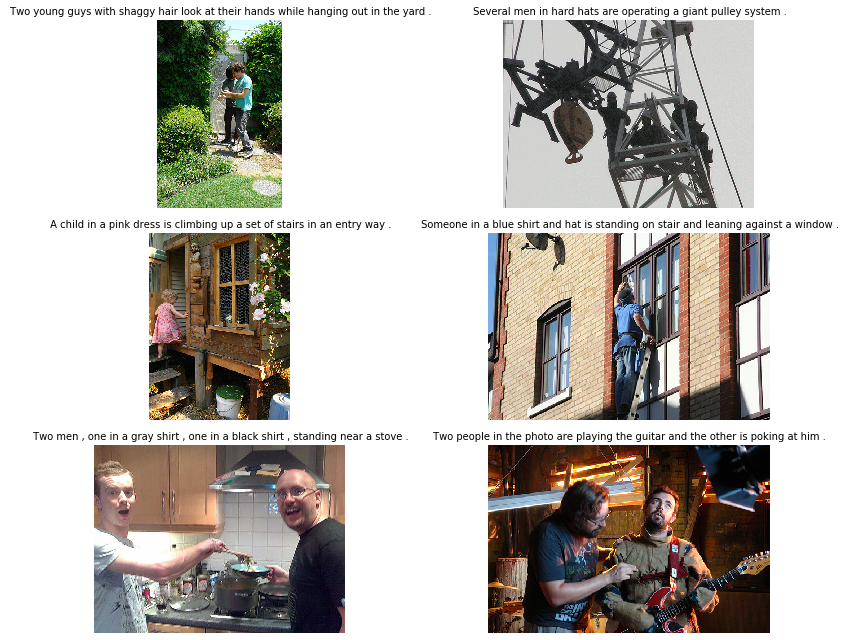

In [9]:
examples = df[df[' comment_number']==' 0'].reset_index().loc[0:5,['image_name', ' comment']]
fig = plt.figure(figsize=(12, 9))
for i,(example_img, example_caption) in examples.iterrows():
    img = cv2.imread(os.path.join(BASE_DIR, IMAGES_DIR, example_img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    ax = fig.add_subplot(3, 2, i+1)
    ax.imshow(img)
    ax.set_title(example_caption, size=10)
    ax.set_axis_off()
plt.tight_layout()
plt.show()

## Build a Vocabulary

In [10]:
class CaptionsTokenizer:
    """
    This class allows to vectorize captions, by turning each text into a sequence of integers
     (each integer being the index of a token in a dictionary)
    """
    def __init__(self, max_unk_freq):
        """
        Args:
            max_unk_freq (int): Maximum frequency for a token to be considered unknown and be replaced with <UNK> token.
        """
        self.max_unk_freq = max_unk_freq
        self.convert_str_idx = {'<PAD>': 0, '<UNK>': 2, '<SOS>': 3, '<EOS>': 4}
        self.convert_idx_str = {v: k for k, v in self.convert_str_idx.items()}
        self.unk = []
        self.nlp = en_core_web_sm.load()

    def _tokenize(self, caption):
        """
        This method separates a caption into a sequence of tokens
        Args:
            caption (str): A text with a caption of an image
        Returns:
            a sequence of the caption's tokens
        """
        return [token.text for token in
                self.nlp.tokenizer(str(caption).lower().strip())]

    def fit_on_text(self, captions):
        """
        This method is building a vocabulary based on the given captions and creates the mapping from indexes to tokens.
        Args:
            captions (list): A  list of texts with captions of images

        """
        tokenized_captions = []
        for caption in captions:
            tokenized_text = self._tokenize(caption)
            tokenized_captions.append(tokenized_text)
        tok_count = Counter(np.hstack(tokenized_captions))
        i = max(self.convert_idx_str.keys()) + 1
        for word, n in tok_count.items():
            if n > self.max_unk_freq:
                self.convert_str_idx[word] = i
                self.convert_idx_str[i] = word
                i += 1
            else:
                self.unk.append(word)

    def text_to_sequence(self, caption):
        """
        This method takes a text and converts it to a numerical sequence based on the
         fitted vocabulary mapping (fit_on_text should be called first), including adding start, end and unknown tokens.
        Args:
            caption (str): A text with a caption of an image
        Returns:
            a sequence of the caption's tokens in their numeric representation, based on the mapping 
            created when fit_on_text was called
        """
        tokenized_text = self._tokenize(caption)
        numerical_sequence = [
            self.convert_str_idx[token] if token in self.convert_str_idx
            else self.convert_str_idx["<UNK>"] for token in tokenized_text
        ]
        return [self.convert_str_idx['<SOS>']] + numerical_sequence + [self.convert_str_idx['<EOS>']]


Check that our class is working properly:

In [11]:
tok = CaptionsTokenizer(2)
tok.fit_on_text(df[' comment'].to_list())

Number of non frequent words in our vocabulary, which we will set to unknown:

In [12]:
len(tok.unk)

8534

Number of unique tokens in our vocabulary:

In [13]:
len(tok.convert_idx_str)

9859

Example of text_to_sequence:

In [14]:
df.loc[10,' comment']

' A child in a pink dress is climbing up a set of stairs in an entry way .'

In [15]:
tok.text_to_sequence(df.loc[10,' comment'])

[3, 34, 69, 18, 34, 70, 71, 72, 73, 53, 34, 74, 57, 75, 18, 76, 77, 78, 21, 4]

In [16]:
tok.convert_idx_str

{0: '<PAD>',
 2: '<UNK>',
 3: '<SOS>',
 4: '<EOS>',
 5: 'two',
 6: 'young',
 7: 'guys',
 8: 'with',
 9: 'shaggy',
 10: 'hair',
 11: 'look',
 12: 'at',
 13: 'their',
 14: 'hands',
 15: 'while',
 16: 'hanging',
 17: 'out',
 18: 'in',
 19: 'the',
 20: 'yard',
 21: '.',
 22: ',',
 23: 'white',
 24: 'males',
 25: 'are',
 26: 'outside',
 27: 'near',
 28: 'many',
 29: 'bushes',
 30: 'men',
 31: 'green',
 32: 'shirts',
 33: 'standing',
 34: 'a',
 35: 'man',
 36: 'blue',
 37: 'shirt',
 38: 'garden',
 39: 'friends',
 40: 'enjoy',
 41: 'time',
 42: 'together',
 43: 'several',
 44: 'hard',
 45: 'hats',
 46: 'operating',
 47: 'giant',
 48: 'pulley',
 49: 'system',
 50: 'workers',
 51: 'down',
 52: 'from',
 53: 'up',
 54: 'above',
 55: 'on',
 56: 'piece',
 57: 'of',
 58: 'equipment',
 59: 'working',
 60: 'machine',
 61: 'wearing',
 62: 'four',
 63: 'top',
 64: 'tall',
 65: 'structure',
 66: 'three',
 67: 'large',
 68: 'rig',
 69: 'child',
 70: 'pink',
 71: 'dress',
 72: 'is',
 73: 'climbing',
 74: '

## Build the Dataset

In [17]:
class CaptionsDataset(Dataset):
    """
    Build a custom torch dataset for captions and images
    """
    def __init__(self, captions_file, images_dir, transform=None, max_unk_freq=2):
        """
        Args:
            captions_file (str): Path to the csv file with the captions, the first column should be the image name,
            the second column should be the number of image's caption and the third column should be the caption's text.
            images_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_unk_freq (int): Maximum frequency for a token to be considered unknown and be replaced with <UNK> token.
        """
        self.df = pd.read_csv(captions_file, delimiter='|', header=0, names=['image_name', 'caption_number', 'caption'])
        self.images_dir = images_dir
        self.transform = transform
        self.images_names = self.df['image_name']
        self.captions = self.df['caption']

        # Initialize the tokenizer based on the captions
        self.tokenizer = CaptionsTokenizer(max_unk_freq)
        self.tokenizer.fit_on_text(self.captions.to_list())

    def __len__(self):
        """Returns the length of the dataset"""
        return self.df.shape[0]

    def __getitem__(self, idx):
        """
        This method return a single item from the dataset on the specified index.
         An item consists of an image and a caption
        Args:
            idx (int): index of the desired item in the dataset
        Returns:
            (tuple) An image and a numerical sequence tensor representing a caption
        """
        caption = self.captions[idx]
        image_name = self.images_names[idx]
        image = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")
    
        if self.transform is not None:
            image = self.transform(image)
        sequence = self.tokenizer.text_to_sequence(caption)
        return image, torch.tensor(sequence)

In [18]:
x = np.zeros((3, 4, 5))
np.moveaxis(x, 0, 2).shape

(4, 5, 3)

0 torch.Size([3, 224, 224]) torch.Size([19])
1 torch.Size([3, 224, 224]) torch.Size([14])
2 torch.Size([3, 224, 224]) torch.Size([20])
3 torch.Size([3, 224, 224]) torch.Size([19])


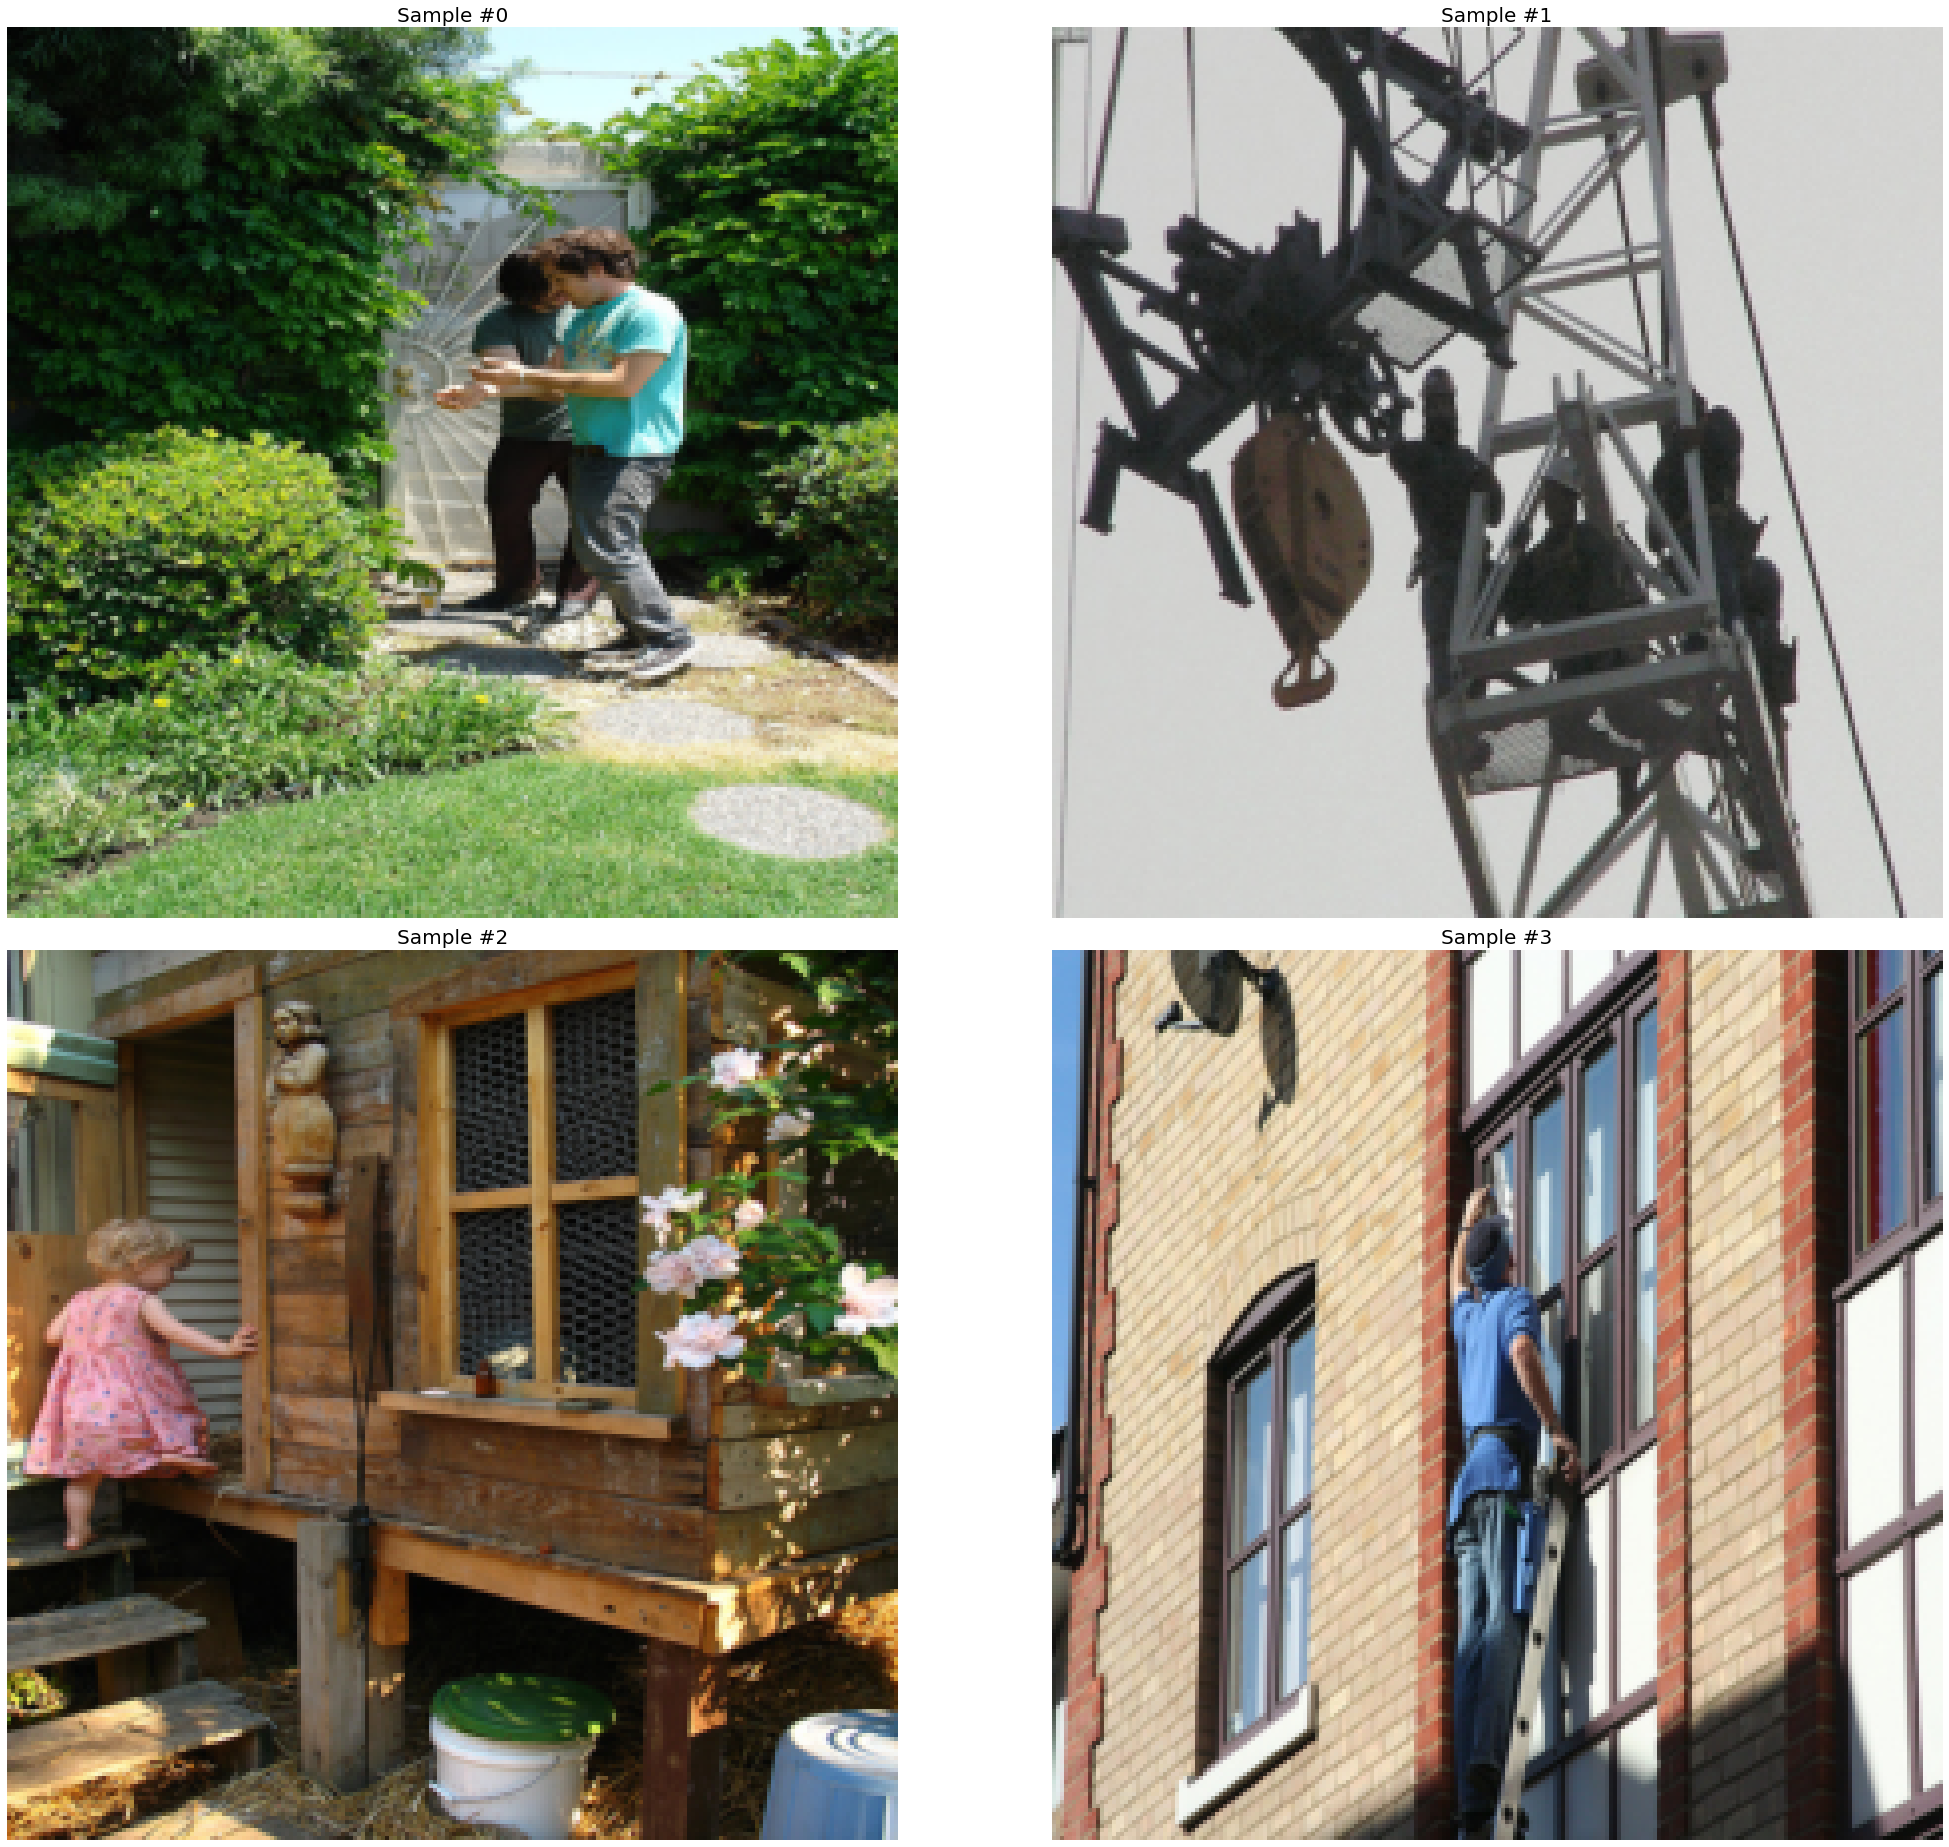

In [20]:
transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor()]
    )
flickr_dataset = CaptionsDataset(captions_file=os.path.join(BASE_DIR, CAPTIONS_DIR, CAPTIONS_FILE),
                                    images_dir=os.path.join(BASE_DIR, IMAGES_DIR), transform=transform)

fig = plt.figure(figsize=(30,26))

for i in range(len(flickr_dataset)):
    sample = flickr_dataset[i*5]
    print(i, sample[0].shape, sample[1].shape)
    ax = plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i), size=20)
    ax.axis('off')
    plt.imshow(sample[0].transpose(0,2).transpose(0,1)) # channels first to last

    if i == 3:
        plt.show()
        break

In [35]:
class CaptionsLoader:
    def __init__(self, captions_file, images_dir, transform,
                 batch_size=32, num_workers=8, shuffle=True, pin_memory=True, max_unk_freq=2):
        self.captions_file = captions_file
        self.images_dir = images_dir
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = 8
        self.shuffle = shuffle
        self.pin_memory = True
        self.dataset = CaptionsDataset(captions_file, images_dir, transform, max_unk_freq)

    def _generate_batch(self, batch):
        images = []
        captions = []
        for image, caption in batch:
            image = image.unsqueeze(0)
            images.append(image)
            captions.append(caption)
        captions = pad_sequence(captions, batch_first=True,
                              padding_value=self.dataset.tokenizer.convert_str_idx['<PAD>'])
        return torch.cat(images, dim=0), captions

    def get_loader(self):
        data_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle,
                                 num_workers=self.num_workers, collate_fn=self._generate_batch,
                                 pin_memory=self.pin_memory)
        return data_loader, self.dataset

Test CaptionsLoader:

In [36]:
captions_file = os.path.join(BASE_DIR, CAPTIONS_DIR, CAPTIONS_FILE)
images_dir = os.path.join(BASE_DIR, IMAGES_DIR)
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(), ]
)

cl = CaptionsLoader(captions_file, images_dir, transform,
                    batch_size=32, num_workers=8, shuffle=True,
                    pin_memory=True, max_unk_freq=2)
loader, dataset = cl.get_loader()
for idx, (iamges, captions) in enumerate(loader):
    print(iamges.shape)
    print(captions.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 60])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 55])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 41])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 51])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 46])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 51])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 41])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 53])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 55])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 56])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 41])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 50])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 46])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 54])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 56])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 55])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 44])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 41])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 54])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 41])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 55])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 48])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 51])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 46])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 19])
torch.Size([32, 3, 224, 224])
torch.Size([32, 44])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 47])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 48])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 22])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 40])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 39])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 23])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 36])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 38])
torch.Size([32, 3, 224, 224])
torch.Size([32, 61])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 43])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 32])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 25])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 28])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
t

torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 37])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 35])
torch.Size([32, 3, 224, 224])
torch.Size([32, 29])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 31])
torch.Size([32, 3, 224, 224])
torch.Size([32, 34])
torch.Size([32, 3, 224, 224])
torch.Size([32, 27])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 24])
torch.Size([32, 3, 224, 224])
torch.Size([32, 33])
torch.Size([32, 3, 224, 224])
torch.Size([32, 42])
torch.Size([32, 3, 224, 224])
t